# My Clustering Project
### Which neighborhoods should I visit on my trip to Seattle?

## Part I - Introduction

My sister moved to Seattle before the pandemic and I *still* haven't been able to visit. I hope I'll be able to someday soon. In the meantime, I'm going to go ahead and figure out where to stay. Seattle is a big city, so I'll narrow down my search by first determining which of the seven Council Districts I'd like to stay in. To do this, I'll compare each district to some of my favorite vacation destinations over the last decade using clustering and data from Foursquare. The result will help me place each district within the context of my previous vacations and best select a district to stay in.

My source data will come in two forms: geolocation data for the districts/destinations and venue data from Foursquare within an appropriate radius of each district/destination. The data from the vacation destinations will be transformed and a cluster analysis will be conducted. After a suitable model has been chosen, the Seattle district data will be scored. The results will illustrate similarities between each district and destinations I've visited in previous travels.

In [73]:
# import packages
import pandas as pd
import folium
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## Part II - Data

My source data is a hand-crafted list of neighborhoods I have visited on previous trips and vacations.  It includes the name of the neighborhood, municipality, region, country, latitude, and longitude.  I will import the data and then prepare it for kmeans processing using one hot encoding, standardization, and principal component scoring.

In [2]:
# import my vacation data and inspect
vacation = pd.read_csv('./data/vacation_geo.csv')
vacation['Name'] = vacation[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(vacation.columns)
print(vacation.shape)
vacation.head()

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(47, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Highland,Denver,Colorado,USA,39.761133,-105.026392,"Highland, Denver, Colorado, USA"
1,Lodo,Denver,Colorado,USA,39.758270,-104.997257,"Lodo, Denver, Colorado, USA"
2,River North,Denver,Colorado,USA,39.768557,-104.980489,"River North, Denver, Colorado, USA"
3,Manitou Springs,Manitou Springs,Colorado,USA,38.854896,-104.898813,"Manitou Springs, Manitou Springs, Colorado, USA"
4,Downtown,Atlanta,Georgia,USA,33.759502,-84.387993,"Downtown, Atlanta, Georgia, USA"


In [3]:
# check location data
vacation[['Region','Country']].value_counts()

Region          Country
Ontario         Canada     11
Quebec          Canada      5
Georgia         USA         5
Tokyo           Japan       4
Florida         USA         4
Colorado        USA         4
California      USA         3
Tennessee       USA         2
South Carolina  USA         2
Kyoto           Japan       2
Yamanashi       Japan       1
Osaka           Japan       1
Nara            Japan       1
Louisiana       USA         1
Alabama         USA         1
dtype: int64

In [4]:
# visualize vacation locations
latitude = vacation.lat.mean()
longitude = (vacation.lon.max() + vacation.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=2)

# add markers to map
for lat, lng, name in zip(vacation['lat'], 
                          vacation['lon'],
                          vacation['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [5]:
# set foursquare credentials and version
CLIENT_ID = os.getenv('FOURSQUARE_CLIENT_ID')
CLIENT_SECRET = os.getenv('FOURSQUARE_CLIENT_SECRET')
VERSION = '20180605'
LIMIT = 100

In [6]:
# define function to pull venue information
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Name Latitude', 
                  'Name Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
# call function to get venue information
vacation_venues = getNearbyVenues(names=vacation['Name'],
                                 latitudes=vacation['lat'],
                                 longitudes=vacation['lon']
                                )
print("All done!")

All done!


In [8]:
# check venue data
print(vacation_venues.shape)
vacation_venues.head()

(2807, 7)


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Highland Park,39.762880,-105.026054,Park
1,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Orangetheory Fitness,39.762002,-105.030061,Gym
2,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Tacos Tequila Whiskey,39.762012,-105.030019,Taco Place
3,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Starbucks,39.760393,-105.024941,Coffee Shop
4,"Highland, Denver, Colorado, USA",39.761133,-105.026392,Denver Bread Company,39.762274,-105.030000,Bakery


There are 324 unique venue categories.

Lots of coffee shops!
count            2807
unique            324
top       Coffee Shop
freq              140
Name: Venue Category, dtype: object 

Coffee Shop            140
Café                   124
Hotel                  114
Japanese Restaurant     76
Bar                     69
Pizza Place             57
Italian Restaurant      55
Restaurant              47
Bakery                  38
Park                    37
Name: Venue Category, dtype: int64 

Coffee Shop            0.049875
Café                   0.044175
Hotel                  0.040613
Japanese Restaurant    0.027075
Bar                    0.024581
Pizza Place            0.020306
Italian Restaurant     0.019594
Restaurant             0.016744
Bakery                 0.013538
Park                   0.013181
Name: Venue Category, dtype: float64 

Fabric Shop                1
Bus Stop                   1
Gym Pool                   1
Multiplex                  1
Cycle Studio               1
S

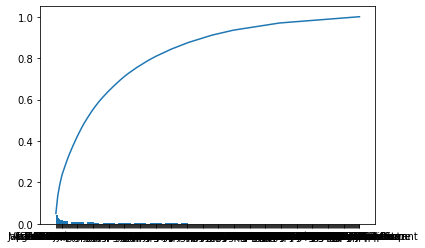

In [75]:
# inspect venue data
print('There are {} unique venue categories.\n'.format(len(vacation_venues['Venue Category'].unique())))
print("Lots of coffee shops!")
print(vacation_venues['Venue Category'].describe(),'\n')
t = vacation_venues['Venue Category'].value_counts(normalize=True)
n = vacation_venues['Venue Category'].value_counts()
print(n.head(10),'\n')
print(t.head(10),'\n')
print(n.tail(10),'\n')
x = t.index.values
h = t.values
c = h.cumsum()
plt.bar(x, h)
plt.plot(x, c)

## Part II - Define Features and Fit Kmeans

In [29]:
# derive features with one hot encoding
vacation_onehot = pd.get_dummies(vacation_venues[['Venue Category']], prefix="", prefix_sep="")

# add Name column back to dataframe
vacation_onehot['Name'] = vacation_venues['Name'] 

# move Name column to the first column
fixed_columns = [vacation_onehot.columns[-1]] + list(vacation_onehot.columns[:-1])
vacation_onehot = vacation_onehot[fixed_columns]

name_counts = vacation_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
q = name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1])
print(q, '\n')
vacation_hot_counts = vacation_onehot.merge(name_counts, on='Name')

print(vacation_hot_counts.shape,'\n')
print('Some locations have as few as', q.loc[0, :][0], 'venues')
print('Some have up to', q.loc[1.00, :][0])
print('The median is', q.loc[0.50, :][0])

       Count
0.00    2.00
0.05    7.00
0.10    9.20
0.25   29.50
0.33   39.00
0.50   61.00
0.67   95.46
0.75  100.00
0.90  100.00
0.95  100.00
1.00  100.00 

(2807, 326) 

Some locations have as few as 2.0 venues
Some have up to 100.0
The median is 61.0


In [30]:
# look for locations with few venues
mask = name_counts['Count'] < 10
name_counts[mask].sort_values('Count')

,Name,Count
46,"Mountain Top, Mentone, Alabama, USA",2
45,"Tybee Island, Savannah, Georgia, USA",3
43,"Cinco Bayou, Fort Walton Beach, Florida, USA",7
44,"Little River, Little River, California, USA",7
42,"PCB, Panama City Beach, Florida, USA",8


In [31]:
# group by Name and take mean by venue type
vacation_grouped = vacation_hot_counts.groupby('Name').mean().reset_index()
print(vacation_grouped.shape)
vacation_grouped.head()

(47, 326)


,Name,Accessories Store,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Art Gallery,Art Museum,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Count
0,"Alexandra Park, Toronto, Ontario, Canada",0.0,0.0,0.01,0.0,0.0,0.01,0.02,0.020000,0.000000,...,0.0,0.010000,0.01,0.0,0.0,0.0,0.0,0.020000,0.00,100
1,"Asakusa, Taitō, Tokyo, Japan",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.04,100
2,"Casa Loma, Toronto, Ontario, Canada",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.000000,0.000000,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.034483,0.00,29
3,"Chinatown, Montreal, Quebec, Canada",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.021505,0.021505,...,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,93
4,"Chinatown, Toronto, Ontario, Canada",0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.017857,0.000000,...,0.0,0.017857,0.00,0.0,0.0,0.0,0.0,0.000000,0.00,56


In [32]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
X = np.nan_to_num(X)
pca_dataset = StandardScaler().fit_transform(X)

           0    cumsum
0   0.059382  0.059382
1   0.046581  0.105963
2   0.046025  0.151988
3   0.044268  0.196256
4   0.042677  0.238933
5   0.039341  0.278275
6   0.037827  0.316102
7   0.036801  0.352903
8   0.036165  0.389068
9   0.035572  0.424640
10  0.033642  0.458282
11  0.032173  0.490456
12  0.031260  0.521715
13  0.029914  0.551629
14  0.029617  0.581246
15  0.028964  0.610210
16  0.028041  0.638251
17  0.027455  0.665706
18  0.026990  0.692696
19  0.025058  0.717754 

                                       Name         0         1
0  Alexandra Park, Toronto, Ontario, Canada  0.017548 -0.019234
1              Asakusa, Taitō, Tokyo, Japan -0.049546 -0.009733
2       Casa Loma, Toronto, Ontario, Canada  0.031610 -0.017798
3       Chinatown, Montreal, Quebec, Canada  0.018389 -0.029976
4       Chinatown, Toronto, Ontario, Canada  0.040859  0.021422 



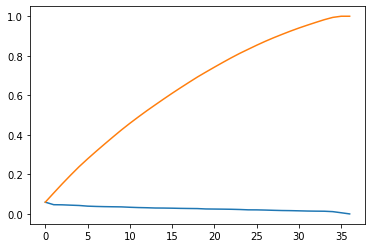

In [50]:
# run a principal component analysis
pca = PCA()
pca.fit(pca_dataset)
pca_comps = pd.DataFrame(pca.components_)
pca_comps['Name'] = vacation_grouped['Name'] 
pca_plot = pca_comps.iloc[:, [-1, 0, 1]]
pca_var = pd.DataFrame(pca.explained_variance_ratio_)
pca_var['cumsum'] = pca.explained_variance_ratio_.cumsum()
print(pca_var.head(20),'\n')
print(pca_comps.iloc[0:5, [-1, 0, 1]],'\n')
plt.plot(pca_var, '-')

In [52]:
# determine best number of clusters
vacation_grouped_clustering = pca_comps.iloc[:, 0:25]
sil = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k).fit(vacation_grouped_clustering)
    sil.append([silhouette_score(vacation_grouped_clustering, kmeans.labels_)])
    print("K: ",k)
    print("Clusters:")
    # check cluster labels generated for each row in the dataframe
    print(pd.DataFrame(kmeans.labels_).value_counts())
    # Calculate silhouette_score
    print("Silhouette: ",silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")
    
np.mean(sil)

K:  2
Clusters:
0    36
1     1
dtype: int64
Silhouette:  0.5357272128798565 

K:  3
Clusters:
2    19
0    17
1     1
dtype: int64
Silhouette:  0.0640850133523018 

K:  4
Clusters:
0    17
3    10
1     9
2     1
dtype: int64
Silhouette:  0.055328382422673135 

K:  5
Clusters:
2    15
0    12
3     7
4     2
1     1
dtype: int64
Silhouette:  0.06974923838264166 

K:  6
Clusters:
2    11
4     9
0     8
3     7
5     1
1     1
dtype: int64
Silhouette:  0.03393725772191512 

K:  7
Clusters:
5    10
3     8
0     8
2     6
6     3
4     1
1     1
dtype: int64
Silhouette:  0.042623838863696605 

K:  8
Clusters:
5    8
1    8
6    7
4    4
0    4
2    3
7    2
3    1
dtype: int64
Silhouette:  0.035413733817556206 

K:  9
Clusters:
0    8
7    6
2    6
1    5
4    4
8    3
6    2
3    2
5    1
dtype: int64
Silhouette:  0.05586784044968429 

K:  10
Clusters:
3    9
4    5
0    5
9    4
8    4
1    4
6    3
7    1
5    1
2    1
dtype: int64
Silhouette:  0.06189900986253019 

K:  11
Clusters:


0.09205297901157297

In [53]:
# fit a k-means using the selected number of clusters
kmeans = KMeans(n_clusters=7).fit(vacation_grouped_clustering)
print(pd.DataFrame(kmeans.labels_).value_counts())
print("Silhouette: ", silhouette_score(vacation_grouped_clustering, kmeans.labels_),"\n")

4    9
1    9
0    8
3    5
6    4
5    1
2    1
dtype: int64
Silhouette:  0.06040055791080767 



## Part III - Import and Process the Seattle Neighborhoods

In [76]:
# import seattle data
seattle = pd.read_csv('./data/seattle_geo.csv')
seattle['Name'] = seattle[['Neighborhood', 'Municipality', 'Region', 'Country']].agg(', '.join, axis=1)
print(seattle.columns)
print(seattle.shape)
seattle

Index(['Neighborhood', 'Municipality', 'Region', 'Country', 'lat', 'lon',
       'Name'],
      dtype='object')
(17, 7)


,Neighborhood,Municipality,Region,Country,lat,lon,Name
0,Downtown,Seattle,Washington,USA,47.607581,-122.336146,"Downtown, Seattle, Washington, USA"
1,West Seattle,Seattle,Washington,USA,47.566933,-122.387116,"West Seattle, Seattle, Washington, USA"
2,Capitol Hill,Seattle,Washington,USA,47.625067,-122.321201,"Capitol Hill, Seattle, Washington, USA"
3,Ballard,Seattle,Washington,USA,47.677038,-122.386494,"Ballard, Seattle, Washington, USA"
4,Queen Anne,Seattle,Washington,USA,47.632492,-122.357077,"Queen Anne, Seattle, Washington, USA"
5,Fremont,Seattle,Washington,USA,47.652553,-122.351225,"Fremont, Seattle, Washington, USA"
6,Lake City,Seattle,Washington,USA,47.719583,-122.295993,"Lake City, Seattle, Washington, USA"
7,Chinatown-International,Seattle,Washington,USA,47.598462,-122.324432,"Chinatown-International, Seattle, Washington, USA"
8,Seattle Waterfront,Seattle,Washington,USA,47.609077,-122.342501,"Seattle Waterfront, Seattle, Washington, USA"
9,Belltown,Seattle,Washington,USA,47.615344,-122.345397,"Belltown, Seattle, Washington, USA"


In [77]:
# visualize Seattle neighborhoods
latitude = seattle.lat.mean()
longitude = (seattle.lon.max() + seattle.lon.min())/2
map_geo = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, name in zip(seattle['lat'], 
                          seattle['lon'],
                          seattle['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_geo)  
    
map_geo

In [78]:
# process the seattle venue data
seattle_venues = getNearbyVenues(names=seattle['Name'],
                                 latitudes=seattle['lat'],
                                 longitudes=seattle['lon']
                                )
print("All done!")

All done!


In [57]:
# inspect the seattle venues
print(seattle_venues.shape)
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))
seattle_venues.head()

(928, 7)
There are 216 uniques categories.


,Name,Name Latitude,Name Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Benaroya Hall,47.607957,-122.336456,Concert Hall
1,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Seattle Art Museum,47.607052,-122.337819,Art Museum
2,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Starbucks Reserve Bar,47.607027,-122.338199,Coffee Shop
3,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Gelatiamo,47.608754,-122.336992,Dessert Shop
4,"Downtown, Seattle, Washington, USA",47.607581,-122.336146,Penelope and The Beauty Bar,47.608117,-122.333872,Spa


In [58]:
# derive features with one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add Name column back to dataframe
seattle_onehot['Name'] = seattle_venues['Name'] 

# move Name column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

name_counts = seattle_onehot.Name.value_counts().reset_index()
name_counts.columns = ['Name', 'Count']
print(name_counts[['Count']].quantile([0,0.05,0.1,0.25,0.33,0.5,0.67,0.75,0.9,0.95,1]),'\n')
seattle_hot_counts = seattle_onehot.merge(name_counts, on='Name')

print(seattle_hot_counts.shape,'\n')
print('Some locations only have a few venues.')
print('Some have up to 100.')

       Count
0.00    6.00
0.05    9.20
0.10   11.20
0.25   31.00
0.33   35.28
0.50   42.00
0.67   78.76
0.75   96.00
0.90  100.00
0.95  100.00
1.00  100.00 

(928, 218) 

Some locations only have a few venues.
Some have up to 100.


In [59]:
# group by Name and take mean by venue type
seattle_grouped = seattle_hot_counts.groupby('Name').mean().reset_index()
print(seattle_grouped.shape)
seattle_grouped.head()

(17, 218)


,Name,ATM,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Video Store,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Count
0,"Ballard, Seattle, Washington, USA",0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.000,0.0,10
1,"Beacon Hill, Seattle, Washington, USA",0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.000,0.0,6
2,"Belltown, Seattle, Washington, USA",0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.012346,0.0,...,0.0,0.0,0.012346,0.0,0.000,0.0,0.0,0.000,0.0,81
3,"Capitol Hill, Seattle, Washington, USA",0.0,0.0,0.1,0.0,0.0,0.0,0.025,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.025,0.0,0.0,0.025,0.0,40
4,"Central District, Seattle, Washington, USA",0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.000,0.0,12


In [64]:
# standardize values
mask = vacation_grouped.Count > 19
X = vacation_grouped[mask].drop('Name', 1)
x_col = X.columns
X = np.nan_to_num(X)
stnd = StandardScaler().fit(X)
S = seattle_grouped.drop('Name', 1)
S = S.reindex(labels=x_col, axis=1)
S = np.nan_to_num(S)
seattle_stnd = stnd.transform(S)
S.shape

(17, 325)

In [62]:
# score the data with the pca fit above
seattle_pca = pca.transform(seattle_stnd)
seattle_comps = pd.DataFrame(seattle_pca)
seattle_comps['Name'] = seattle_grouped['Name'] 
seattle_comps.iloc[0:5, [-1, 0, 1]]
seattle_grouped_clustering = seattle_comps.iloc[:, 0:25]

,Name,0,1
0,"Ballard, Seattle, Washington, USA",-4.015028,3.570960
1,"Beacon Hill, Seattle, Washington, USA",7.226809,-0.339894
2,"Belltown, Seattle, Washington, USA",-1.585941,0.029908
3,"Capitol Hill, Seattle, Washington, USA",-1.229733,0.270013
4,"Central District, Seattle, Washington, USA",-1.684679,-3.652127


In [65]:
# score the data with the kmeans fit above
seattle_clusters = kmeans.predict(seattle_grouped_clustering)
seattle_clusters[0:5]

array([5, 2, 3, 5, 5])

In [66]:
# add clustering labels
seattle_labeled = seattle_comps.copy()
seattle_labeled.insert(0, 'Cluster Labels', seattle_clusters)
print(seattle_labeled['Cluster Labels'].value_counts())
seattle_labeled.iloc[:, [0,-1]]

5    9
2    5
3    2
6    1
Name: Cluster Labels, dtype: int64


,Cluster Labels,Name
0,5,"Ballard, Seattle, Washington, USA"
1,2,"Beacon Hill, Seattle, Washington, USA"
2,3,"Belltown, Seattle, Washington, USA"
3,5,"Capitol Hill, Seattle, Washington, USA"
4,5,"Central District, Seattle, Washington, USA"
5,2,"Chinatown-International, Seattle, Washington, USA"
6,5,"Downtown, Seattle, Washington, USA"
7,5,"Fremont, Seattle, Washington, USA"
8,2,"Georgetown, Seattle, Washington, USA"
9,3,"Lake City, Seattle, Washington, USA"


In [68]:
# add clustering labels
vacation_labeled = pca_comps.copy()
vacation_labeled.insert(0, 'Cluster Labels', kmeans.labels_)
combined_labeled = pd.concat([vacation_labeled.iloc[:,[0,-1]], seattle_labeled.iloc[:,[0,-1]]], ignore_index=True)
combined_labeled.head()

,Cluster Labels,Name
0,4,"Alexandra Park, Toronto, Ontario, Canada"
1,6,"Asakusa, Taitō, Tokyo, Japan"
2,0,"Casa Loma, Toronto, Ontario, Canada"
3,4,"Chinatown, Montreal, Quebec, Canada"
4,0,"Chinatown, Toronto, Ontario, Canada"


In [70]:
# the clustered seattle data
seattle_labeled.iloc[:,[0,-1]]

,Cluster Labels,Name
0,5,"Ballard, Seattle, Washington, USA"
1,2,"Beacon Hill, Seattle, Washington, USA"
2,3,"Belltown, Seattle, Washington, USA"
3,5,"Capitol Hill, Seattle, Washington, USA"
4,5,"Central District, Seattle, Washington, USA"
5,2,"Chinatown-International, Seattle, Washington, USA"
6,5,"Downtown, Seattle, Washington, USA"
7,5,"Fremont, Seattle, Washington, USA"
8,2,"Georgetown, Seattle, Washington, USA"
9,3,"Lake City, Seattle, Washington, USA"


In [72]:
# combined cluster distribution
combined_labeled['Cluster Labels'].value_counts()

5    10
4     9
1     9
0     8
3     7
2     6
6     5
Name: Cluster Labels, dtype: int64

In [73]:
# cluster 0
print('Cluster 0')
mask0 = combined_labeled['Cluster Labels'] == 0
combined_labeled.loc[mask0]

Cluster 0


,Cluster Labels,Name
31,0,"Midtown, Atlanta, Georgia, USA"
34,0,"Mountain Top, Mentone, Alabama, USA"
39,0,"Belltown, Seattle, Washington, USA"
40,0,"Capitol Hill, Seattle, Washington, USA"
44,0,"Fremont, Seattle, Washington, USA"
48,0,"Queen Anne, Seattle, Washington, USA"


In [68]:
# cluster 1
print('Cluster 1')
mask0 = combined_labeled['Cluster Labels'] == 1
combined_labeled.loc[mask0, combined_labeled.columns[[0,-1]]]

Cluster 1


,Cluster Labels,Name
0,1,"Alexandra Park, Toronto, Ontario, Canada"
3,1,"Chinatown, Montreal, Quebec, Canada"
4,1,"Chinatown, Toronto, Ontario, Canada"
5,1,"Church and Wellesley, Toronto, Ontario, Canada"
11,1,"Downtown, Gatlinburg, Tennessee, USA"
12,1,"Downtown, Memphis, Tennessee, USA"
14,1,"Downtown, Montreal, Quebec, Canada"
19,1,"Garden District, Toronto, Ontario, Canada"
20,1,"Ginza, Chūō, Tokyo, Japan"
21,1,"Harbourfront, Toronto, Ontario, Canada"


In [75]:
# cluster 2
print('Cluster 2')
mask0 = combined_labeled['Cluster Labels'] == 2
combined_labeled.loc[mask0]

Cluster 2


,Cluster Labels,Name
36,2,"Old Montreal, Montreal, Quebec, Canada"
38,2,"Beacon Hill, Seattle, Washington, USA"
42,2,"Chinatown-International, Seattle, Washington, USA"


In [71]:
# cluster 3
print('Cluster 3')
mask0 = combined_labeled['Cluster Labels'] == 3
combined_labeled.loc[mask0]

Cluster 3


,Cluster Labels,Name
13,3,"Downtown, Mendocino, California, USA"
25,3,"Kensington Market, Toronto, Ontario, Canada"
26,3,"Lake Kawaguchi, Fujikawaguchiko, Yamanashi, Japan"
29,3,"Lodo, Denver, Colorado, USA"
32,3,"Mile End, Montreal, Quebec, Canada"
43,3,"Downtown, Seattle, Washington, USA"
47,3,"Pioneer Square, Seattle, Washington, USA"
49,3,"Seattle Waterfront, Seattle, Washington, USA"
52,3,"Wallingford, Seattle, Washington, USA"


In [70]:
# cluster 4
print('Cluster 4')
mask0 = combined_labeled['Cluster Labels'] == 4
combined_labeled.loc[mask0]

Cluster 4


,Cluster Labels,Name
9,4,"Downtown, Atlanta, Georgia, USA"
10,4,"Downtown, Charleston, South Carolina, USA"
15,4,"Downtown, Ukiah, California, USA"
17,4,"Financial District, Toronto, Ontario, Canada"
23,4,"Highland, Denver, Colorado, USA"
24,4,"Historic District, Savannah, Georgia, USA"
28,4,"Little River, Little River, California, USA"
41,4,"Central District, Seattle, Washington, USA"
46,4,"Lake City, Seattle, Washington, USA"
50,4,"SoDo, Seattle, Washington, USA"


In [74]:
# cluster 5
print('Cluster 5')
mask0 = combined_labeled['Cluster Labels'] == 5
combined_labeled.loc[mask0]

Cluster 5


,Cluster Labels,Name
1,5,"Asakusa, Taitō, Tokyo, Japan"
2,5,"Casa Loma, Toronto, Ontario, Canada"
7,5,"Destin, Destin, Florida, USA"
8,5,"Distillery District, Toronto, Ontario, Canada"
30,5,"Manitou Springs, Manitou Springs, Colorado, USA"


In [72]:
# cluster 6
print('Cluster 6')
mask0 = combined_labeled['Cluster Labels'] == 6
combined_labeled.loc[mask0]

Cluster 6


,Cluster Labels,Name
6,6,"Cinco Bayou, Fort Walton Beach, Florida, USA"
16,6,"Entertainment District, Toronto, Ontario, Canada"
18,6,"French Quarter, New Orleans, Louisiana, USA"
22,6,"Higashiyama, Kyoto, Kyoto, Japan"
33,6,"Minami, Osaka, Osaka, Japan"
35,6,"Nara Park, Nara, Nara, Japan"
37,6,"Ballard, Seattle, Washington, USA"
45,6,"Georgetown, Seattle, Washington, USA"


In [42]:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html